In [3]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
series = read_csv('CocaCola_Sales_Rawdata.csv', header=0, index_col=0, parse_dates=True)

In [5]:
series

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996
Q2_87,2104.411995
Q3_87,2014.362999
Q4_87,1991.746998
Q1_88,1869.049999


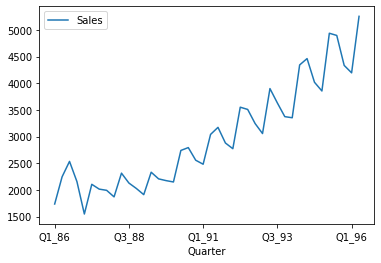

In [6]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series.plot()
pyplot.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab184159d0>]],
      dtype=object)

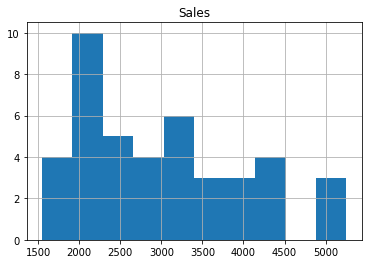

In [7]:
series.hist()

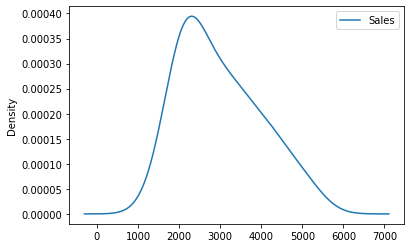

In [8]:
series.plot(kind='kde')

In [9]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 32, Validation 10


#### Persistence/ Base model

In [10]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]


In [11]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=2173.968, Expected=2148.278
>Predicted=2148.278, Expected=2739.308
>Predicted=2739.308, Expected=2792.754
>Predicted=2792.754, Expected=2556.010
>Predicted=2556.010, Expected=2480.974
>Predicted=2480.974, Expected=3039.523
>Predicted=3039.523, Expected=3172.116
>Predicted=3172.116, Expected=2879.001
>Predicted=2879.001, Expected=2772.000
>Predicted=2772.000, Expected=3550.000
>Predicted=3550.000, Expected=3508.000
>Predicted=3508.000, Expected=3243.860
>Predicted=3243.860, Expected=3056.000
>Predicted=3056.000, Expected=3899.000
>Predicted=3899.000, Expected=3629.000
>Predicted=3629.000, Expected=3373.000
RMSE: 387.510


#### ARIMA Hyperparameters

In [12]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [13]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [14]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=840.936
ARIMA(0, 0, 1) RMSE=617.891
ARIMA(0, 0, 2) RMSE=450.670
ARIMA(0, 1, 0) RMSE=389.741
ARIMA(0, 1, 1) RMSE=396.142
ARIMA(0, 1, 2) RMSE=354.964
ARIMA(0, 1, 4) RMSE=272.869
ARIMA(0, 2, 0) RMSE=593.232
ARIMA(0, 2, 1) RMSE=414.867
ARIMA(1, 0, 0) RMSE=470.343
ARIMA(1, 1, 0) RMSE=387.222
ARIMA(1, 2, 0) RMSE=574.838
ARIMA(2, 0, 0) RMSE=493.077
ARIMA(2, 1, 0) RMSE=300.157
ARIMA(2, 1, 1) RMSE=327.956
ARIMA(2, 2, 0) RMSE=485.191
ARIMA(3, 0, 0) RMSE=431.275
ARIMA(3, 1, 0) RMSE=245.267
ARIMA(3, 2, 0) RMSE=156.740
ARIMA(4, 0, 0) RMSE=387.570
ARIMA(4, 1, 0) RMSE=163.620
ARIMA(4, 2, 0) RMSE=161.625
Best ARIMA(3, 2, 0) RMSE=156.740


#### Build Model based on the optimized values

In [15]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [17]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = dataset.values
X = X.astype('float32')

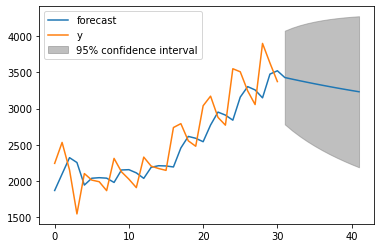

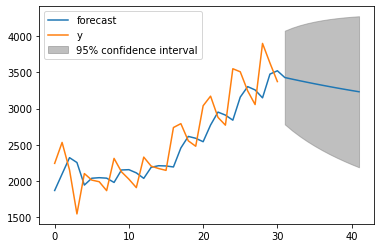

In [25]:
# fit model
model = ARIMA(X, order=(1,0,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 42)

In [26]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

1176.033636508294

#### Combine train and test data and build final model

In [27]:
# fit model
data = read_csv('CocaCola_Sales_Rawdata.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [39]:
model = ARIMA(X, order=(1,0,1))
model_fit = model.fit()

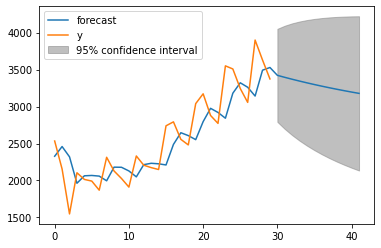

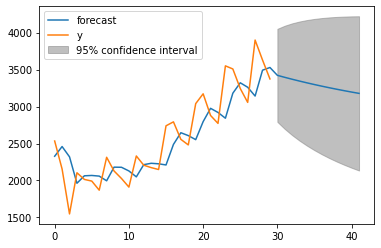

In [40]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,42)

In [41]:
forecast

array([3421.77399798, 3394.7145427 , 3368.75530494, 3343.85155066,
       3319.9603647 , 3297.04057675, 3275.0526905 , 3253.95881551,
       3233.72260193, 3214.3091779 ])